### Install & import necessary packages

In [1]:
!pip install --upgrade gensim -q
!pip install matplotlib -q

     |████████████████████████████████| 24.1 MB 1.6 MB/s 


In [2]:
import gensim
from gensim.models import word2vec          # pre-trained word vectors available in this
from gensim.models.word2vec import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string

In [3]:
np.random.seed(42)

In [4]:
import gensim.downloader as api

# Check the various pre-trained models available in gensim
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In the above cmd output, 'word2vec-ruscorpora-300' means word2vec model trained on ruscorpora dataset with 300 dimensions/features

In [5]:
wv = api.load('glove-twitter-25') # Load the glove model trained on twitter dataset, having 25 features/dimensions

[==================================================] 100.0% 104.8/104.8MB downloaded


In [6]:
type(wv)  # type of word vector: KeyedVectors

gensim.models.keyedvectors.KeyedVectors

Vector representation of word 'Mango'

In [7]:
wv['mango']

array([-1.124  , -0.63226,  0.1913 ,  0.87312, -0.45456,  0.9267 ,
        0.11664, -0.37058,  0.24256, -0.18573,  0.84538, -1.3185 ,
       -2.2011 , -0.79979,  0.35568, -0.47429,  1.3709 , -0.23235,
        0.72   ,  1.3181 , -0.52016,  0.30828,  0.28982,  0.40124,
        0.92812], dtype=float32)

Check the length of vector

In [8]:
len(wv['mango'])  #dimension will be 25 !!

25

You can save and also load the vectors for future use !!

In [9]:
from gensim.models import KeyedVectors

# wv = api.load('word2vec-google-news-300')
# wv.save('/content/drive/MyDrive/Content Creation/Youtube Tutorials/vectors.kv')
 # wv = KeyedVectors.load('/content/drive/MyDrive/Content Creation/Youtube Tutorials/vectors.kv')

Check the similarity between orange and jackfruit

In [10]:
wv.similarity("orange", "jackfruit")  # its pretty bad, but ideally we expect better similarity. This number will improve
# with bigger models, trained on huge datasets and vectors with more no of features (say 300, for example)

0.13519602

In [11]:
wv.similarity("apple", "car")  # this is again not acceptable !!

0.70833313

Few more examples related to similarity between word vectors

In [12]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('bike', 'bicycle'),   # still a wheeled vehicle
    ('flight', 'airplane'),  # ok, no wheels, but still a vehicle
    ('auto', 'tomato'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.50
'bike'	'bicycle'	0.81
'flight'	'airplane'	0.72
'auto'	'tomato'	0.10
'car'	'communism'	0.11


Print words most similar to car and truck

In [13]:
print(wv.most_similar(positive=['car', 'truck'], topn=5))  #print top 5 similar words

[('front', 0.9311097264289856), ('seat', 0.9150131344795227), ('parking', 0.9011927843093872), ('cab', 0.8941381573677063), ('table', 0.8902772665023804)]


Display the ODD ONE OUT word in the list below

In [14]:
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'bike']))

sea


display words similar to woman and king but different to man

In [15]:
wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694)]

In [16]:
wv.most_similar(positive=['woman', 'king'], topn=3)

[('lady', 0.9231982827186584),
 ('called', 0.9227930307388306),
 ("'s", 0.9222202301025391)]

**Visualization of word vectors**

In [18]:
words = ["one",'five','man','king','chair']  # sample words for visualization
sample_vectors = np.array([wv[word] for word in words])
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # visualize on 2D plane (this vector originally has 25 dimensions !!)
result = pca.fit_transform(sample_vectors)
result  #2D vector representation of the words as in line 1

array([[-1.4320724 ,  0.90533096],
       [-0.1070174 ,  2.0883384 ],
       [-1.5798286 , -2.0424688 ],
       [ 0.0723922 , -0.40048406],
       [ 3.0465262 , -0.55071616]], dtype=float32)

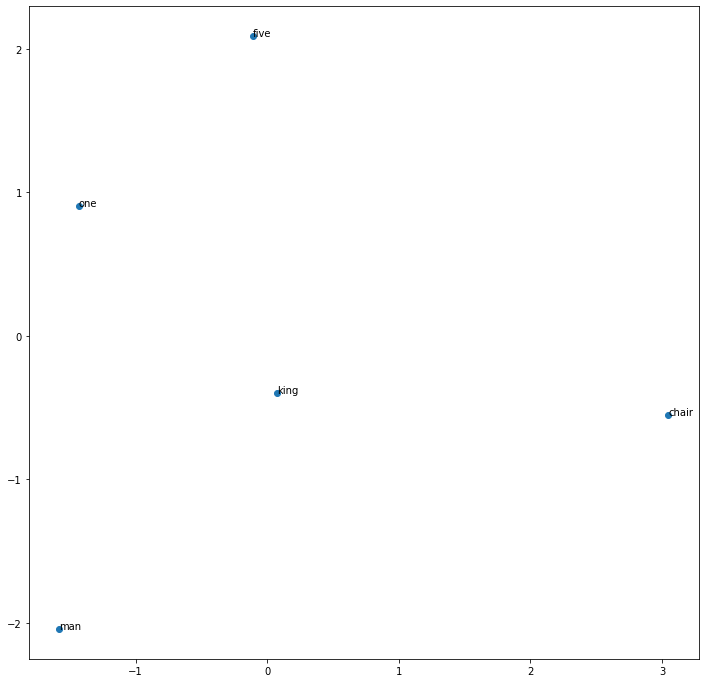

In [19]:
plt.figure(figsize=(12,12))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()  # with better word2vec model with large dimensions, you will see that similar words appear closer in the space !!

**Model with word2vec featurization**

In [20]:
data = pd.read_csv("train.csv",error_bad_lines=False, engine="python")

# Filter out only first 1000 rows & select only 'toxic' & 'comment_text' columns
data = data[:1000][['comment_text', 'toxic']]
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 2431: unexpected end of data


,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Below function takes vector representation of each word, sums it up & then takes average and stores the same of vector representation for the entire sentence

In [21]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)  #create zero matrix and then populate later one by one
    word_count = 1
    for w in sent:    #iterate through each word in the sentence
        if w in wv:
            word_count += 1
            wv_res += wv[w]
    wv_res = wv_res/word_count  # average of word vectors of all the words within a given sentence
    return wv_res

Function for tokenization

In [22]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    doc = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [23]:
sent_vec("I am not feeling good today") #sample sentence vector representation, it has 25 dims !!

array([ 6.85060458e-01,  2.20840913e-01, -9.05847373e-02,  7.85981186e-03,
        3.87013707e-02,  1.83858949e-01, -1.45697546e-01,  1.96917916e+00,
       -2.77963552e-03, -9.44653638e-02, -4.57309088e-01, -1.24269910e+00,
       -3.54199545e+00, -1.12625356e-02, -6.77545453e-01, -4.69620447e-01,
       -8.27152269e-01, -2.76762079e-02, -7.64024546e-01,  2.63502734e-01,
       -1.35344086e-01, -3.12117722e-01,  4.18619231e-01,  3.41334673e-01,
        3.52228813e-01])

In [24]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'‘ve', 'throughout', 'been', 'a', 'sixty', 'now', 'have', 'cannot', 'fifteen', 'even', 'whom', 'further', 'others', 'could', 'either', '’re', 'once', 'me', 'full', 'that', 'latterly', 'who', 'used', 'beforehand', 'them', 'ever', '‘d', 'was', 'most', 'without', 'of', 'to', 'formerly', 'hers', 'towards', 'before', 'nine', 'it', 'ourselves', 'across', 'why', "'re", 'both', 'ca', 'or', "'s", 'so', 'on', 'our', 'herself', 'under', 'when', 'amongst', 'his', 'still', 'such', 'move', 'ten', 'beside', 'these', 'please', 'elsewhere', '’ve', 'hereafter', 'mine', 'are', 'down', "'d", 'yourselves', 'had', 'too', 'themselves', 'seem', 'moreover', 'becoming', 'behind', 'part', '’m', 'everyone', 'during', 'himself', 'thereupon', 'neither', 'well', '’ll', 'yours', 'therein', 'from', 'besides', 'not', 'front', 'if', 'back', 'no', 'up', 'your', 'off', 'anywhere', 'else', 'between', 'really', 'third', 'seeming', 'him', 'after', 'except', 'take', 'would', 'hereupon', 'doing', 'again', 'several', 'each', '

In [25]:
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [26]:
data['tokens'] = data['comment_text'].apply(spacy_tokenizer)  # apply tokenization first
data['vec'] = data['tokens'].apply(sent_vec)  # convert to sentence vectors
data.head(5)

,comment_text,toxic,tokens,vec
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edit, username, hardcore, metall...","[0.12291280907534417, 0.27500737658036606, -0...."
1,D'aww! He matches this background colour I'm s...,0,"[d'aww, match, background, colour, seemingly, ...","[-0.21229873089627785, -0.03393893021116541, -..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, try, edit, war, guy, constantly, re...","[0.2536078045610338, 0.37248320020735265, -0.1..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[real, suggestion, improvement, wonder, sectio...","[0.3082034207153611, 0.2215451443704163, -0.07..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]","[0.09727999940514565, 0.10916283167898655, 0.0..."


In [28]:
X = data['vec'].to_list()  #features
y = data['toxic'].to_list()  #target

In [32]:
X[:5] #observe the first 5 elements: list of arrays for each sentence

[array([ 1.22912809e-01,  2.75007377e-01, -7.54328630e-02, -3.08094479e-02,
         1.92663576e-01, -4.65705214e-01,  4.26312385e-01, -2.17553578e-01,
         3.26301236e-01, -2.62275472e-01, -4.09861459e-03,  1.05846237e-01,
        -2.52248574e+00, -3.00058844e-01,  1.41273811e-01,  4.13665231e-01,
         1.47382223e-01, -1.94045241e-01,  2.18924188e-03, -6.46920928e-02,
        -2.68119382e-01, -3.16457997e-01, -9.44345742e-02, -2.77445862e-01,
        -3.76880864e-01]),
 array([-0.21229873, -0.03393893, -0.04240327, -0.36306563, -0.22737673,
        -0.13472909,  0.91782092, -0.41678499, -0.04983384, -0.06901655,
        -0.29239727,  0.50179527, -2.42513911,  0.25450273,  0.19296728,
         0.1186891 ,  0.29327831, -0.16830326, -0.22334818, -0.04134442,
        -0.35267909, -0.16862203,  0.04587618,  0.24646181, -0.570765  ]),
 array([ 0.2536078 ,  0.3724832 , -0.1846821 , -0.12850703,  0.28936399,
        -0.23278265,  0.8501393 , -0.1701529 ,  0.20807308,  0.12379522,
    

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression()

In [31]:
from sklearn import metrics
predicted = classifier.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.93
Logistic Regression Precision: 0.8888888888888888
Logistic Regression Recall: 0.38095238095238093
